In [5]:
import tensorflow as tf
import numpy as np
import os
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage import color
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [7]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 3


training_images_names = os.listdir('/content/sample_data/Untitled Folder')
training_masks_names = os.listdir('/content/sample_data/mas')

X = np.zeros((len(training_images_names),IMG_HEIGHT,IMG_WIDTH,CHANNELS),dtype='uint8')
y = np.zeros((len(training_masks_names),IMG_HEIGHT,IMG_WIDTH,1))

In [13]:
for i,n in enumerate(training_images_names):
    img = imread(f'/content/sample_data/Untitled Folder/{n}')
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH,CHANNELS),mode='constant',preserve_range=True)
    fn = str(n.split('.')[0]) + '.png'
    mask = imread(f'/content/sample_data/mas/{fn}')
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH,1),mode='constant')

    X[i] = img
    y[i] = mask

X[0].shape

(256, 256, 3)

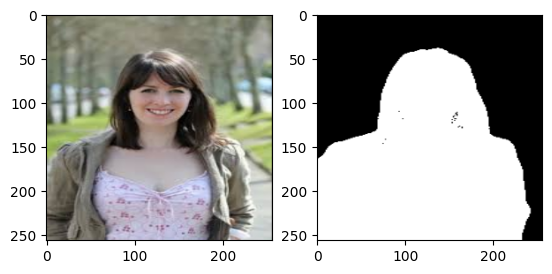

In [14]:
i = np.random.randint(0,len(X))
fig,(a1,a2)=plt.subplots(1,2)
a1.imshow(X[i])
a2.imshow(y[i].reshape(y[i].shape[:-1]),cmap='gray')

In [15]:
inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

#contracting path
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)


c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5_1 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5_1 = tf.keras.layers.Dropout(0.3)(c5_1)
c5_2 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5_1)
c5_3 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_2)
c5_4 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_3 )
c5_5 = tf.keras.layers.concatenate([c5_1,c5_4])


#expanding path
u4 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5_5)
u4 = tf.keras.layers.concatenate([u4,c4])
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)


u3 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(u4)
u3 = tf.keras.layers.concatenate([u3,c3])
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)


u2 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(u3)
u2 = tf.keras.layers.concatenate([u2,c2])
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)


u1 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(u2)
u1 = tf.keras.layers.concatenate([u1,c1])
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)

output = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(u1)

model = tf.keras.Model(inputs=[inputs],outputs=[output])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.1, random_state=42)

In [17]:
results = model.fit(X_train,y_train,batch_size=16,epochs=100)
model.save('models/human_segmentation_non-aug_100_v2.h5')

Epoch 1/100
1/1 [==============================] - 40s 40s/step - loss: 0.8597 - accuracy: 0.4564
Epoch 2/100
1/1 [==============================] - 14s 14s/step - loss: 0.7027 - accuracy: 0.5227
Epoch 3/100
1/1 [==============================] - 7s 7s/step - loss: 0.6727 - accuracy: 0.5567
Epoch 4/100
1/1 [==============================] - 8s 8s/step - loss: 0.6641 - accuracy: 0.5644
Epoch 5/100
1/1 [==============================] - 6s 6s/step - loss: 0.6606 - accuracy: 0.5744
Epoch 6/100
1/1 [==============================] - 8s 8s/step - loss: 0.6562 - accuracy: 0.6142
Epoch 7/100
1/1 [==============================] - 6s 6s/step - loss: 0.6484 - accuracy: 0.6231
Epoch 8/100
1/1 [==============================] - 8s 8s/step - loss: 0.7668 - accuracy: 0.6000
Epoch 9/100
1/1 [==============================] - 6s 6s/step - loss: 0.6504 - accuracy: 0.5953
Epoch 10/100
1/1 [==============================] - 7s 7s/step - loss: 0.6560 - accuracy: 0.5610
Epoch 11/100
1/1 [=================

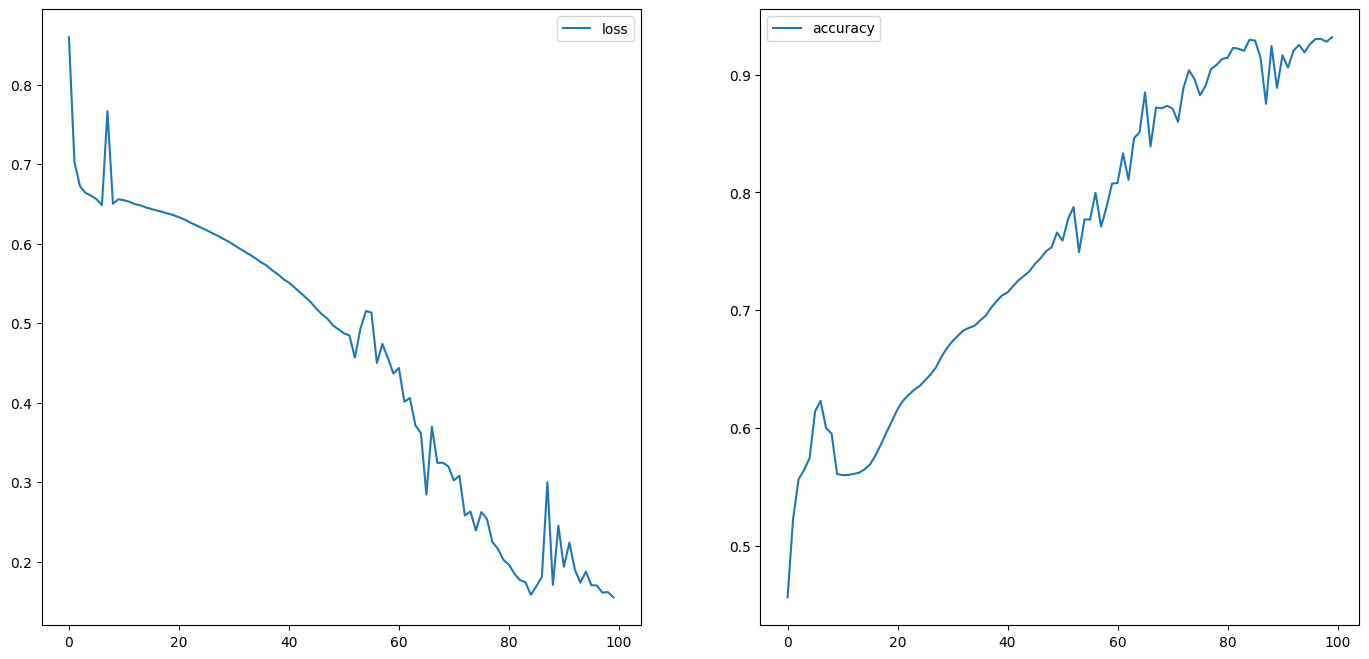

In [18]:
fig,(a1,a2) = plt.subplots(1,2,figsize=(17,8))
a1.plot(np.arange(0,100),results.history['loss'],label = 'loss')
a2.plot(np.arange(0,100),results.history['accuracy'],label='accuracy')
a1.legend()
a2.legend()
plt.savefig('losses_and_accuracies_100_v2.png')

1/1 [==============================] - 2s 2s/step


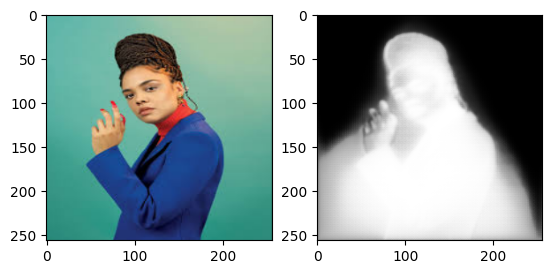

In [19]:
k=np.random.randint(0,len(X_test))
fig,(a1,a2) = plt.subplots(1,2)

a1.imshow(X_test[k])

(h,w,c) = X_test[k].shape
i = X_test[k].reshape((1,h,w,c))

pred = model.predict(i)

a2.imshow(pred.reshape(pred.shape[1:-1]),cmap='gray')